In [1]:
# import packages
import os
from glob import glob
import geopandas as gpd
from pathlib import Path
from typing import List, Union
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
import rioxarray
import xarray as xr
import rasterio as rio
import datetime
from datetime import datetime, timedelta
import sys
from mintpy.utils import readfile, writefile, utils as ut, plot
from mintpy.cli import view, tsview, plot_network, plot_transection
from mintpy.view import prep_slice, plot_slice
import gc
import pandas as pd
import seaborn as sns
from scipy.stats import linregress
import xdem
from rasterio.enums import Resampling
sns.set_theme()

In [2]:
# set up paths, directories, and variables for this specific dam
data_path = '/home/jovyan/repos/fufiters_imja_analysis/data'
asc_burst = '012_023790_IW1'
des_burst = '121_258661_IW2'
asc_burst_path = f'{data_path}/data_igrams/{asc_burst}'
des_burst_path = f'{data_path}/data_igrams/{des_burst}'

dam_name = 'imja'
proc_path = f'/home/jovyan/repos/fufiters_imja_analysis/analysis'

# define reference point, [y, x]
reference_point = [3086715.2, 491092.4]

# define crs 
crs = 32645

In [3]:
# read in dam polygon
dam_fn = f'../mapping/polygons/{dam_name}_md.shp'
dam_gdf = gpd.read_file(dam_fn)
dam_gdf = dam_gdf.to_crs(crs) # reproject in case of mistake

# load in moving area polygon
moving_fn = f'../mapping/polygons/{dam_name}_moving.shp'
moving_gdf = gpd.read_file(moving_fn)

# load in moving area polygon
reference_fn = f'../mapping/polygons/{dam_name}_reference.shp'
reference_gdf = gpd.read_file(reference_fn)

# load in moving area polygon
stable_fn = f'../mapping/polygons/{dam_name}_stable.shp'
stable_gdf = gpd.read_file(stable_fn).to_crs(crs)

# pad dam bounds by 5 km 
padding = 5000
aoi_extent = [dam_gdf.bounds.minx.item()-padding,
               dam_gdf.bounds.maxy.item()+padding,
               dam_gdf.bounds.maxx.item()+padding,
               dam_gdf.bounds.miny.item()-padding]

In [4]:
# write velocity to geotiff

# function to rewrite coordinates from metadata
def coord_range(ds):
    latrange = np.linspace(float(ds.attrs['Y_FIRST']),
                           ((float(ds.attrs['Y_STEP'])*float(ds.attrs['LENGTH']))+float(ds.attrs['Y_FIRST'])),
                           int(ds.attrs['LENGTH']))
    lonrange = np.linspace(float(ds.attrs['X_FIRST']),
                           ((float(ds.attrs['X_STEP'])*float(ds.attrs['WIDTH']))+float(ds.attrs['X_FIRST'])),
                           int(ds.attrs['WIDTH']))
    return latrange, lonrange

def mintpy2d_to_xarray(fn, crs):
    ds = xr.open_dataset(fn, engine='h5netcdf', phony_dims='sort')
    ds = ds.rename_dims({'phony_dim_0':'y',
                         'phony_dim_1':'x'
                        })
    latrange, lonrange = coord_range(ds)
    ds = ds.assign_coords({'y': ('y', latrange),
                          'x': ('x', lonrange)})
    ds = ds.rio.write_crs(crs)
    
    return ds

In [5]:
# function to read time series into xarray
def mintpyTS_to_xarray(fn, crs):
    ds = xr.open_dataset(fn, cache=False)
    ds = ds.rename_dims({'phony_dim_1':'time',
                         'phony_dim_2':'y',
                         'phony_dim_3':'x'})
    ds = ds.rename({'timeseries': 'displacement'})
    latrange, lonrange = coord_range(ds)
    ds = ds.assign_coords({'time': ('time', pd.to_datetime(ds.date)),
                           'y': ('y', latrange),
                           'x': ('x', lonrange)})
    ds = ds.drop(['bperp', 'date'])
    ds = ds.rio.write_crs(crs)
    ds['displacement'] = ds['displacement'] * -1
    
    return ds

In [6]:
asc_mintpy_path = 'asc_insar_mintpy'
des_mintpy_path = 'des_insar_mintpy'

In [7]:
os.chdir(proc_path)
# read ascending and descending time series into xarray ds
asc_ts_fn = f'{asc_mintpy_path}/timeseries.h5'
asc_ts_ds = mintpyTS_to_xarray(asc_ts_fn, crs)
asc_ts_ds = asc_ts_ds.rename({'displacement': 'asc_displacement'})

des_ts_fn = f'{des_mintpy_path}/timeseries.h5'
des_ts_ds = mintpyTS_to_xarray(des_ts_fn, crs)
des_ts_ds = des_ts_ds.rename({'displacement': 'des_displacement'})

# read geometry files into xarray ds
asc_geom_fn = f'{asc_mintpy_path}/inputs/geometryGeo.h5'
des_geom_fn = f'{des_mintpy_path}/inputs/geometryGeo.h5'
asc_geom_ds = mintpy2d_to_xarray(asc_geom_fn, crs)
des_geom_ds = mintpy2d_to_xarray(des_geom_fn, crs)

/tmp/ipykernel_3467/3499342614.py:12: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop(['bperp', 'date'])
/tmp/ipykernel_3467/3499342614.py:12: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop(['bperp', 'date'])


In [8]:
# set reference point with reference area
asc_ts_ds['asc_displacement'] = asc_ts_ds['asc_displacement'] - asc_ts_ds['asc_displacement'].rio.clip(stable_gdf.geometry.values, crs=stable_gdf.crs, drop=True).median(dim=['x', 'y'])
des_ts_ds['des_displacement'] = des_ts_ds['des_displacement'] - des_ts_ds['des_displacement'].rio.clip(stable_gdf.geometry.values, crs=stable_gdf.crs, drop=True).median(dim=['x', 'y'])

In [9]:
# find shorter time series and interpolate
asc_tspan = asc_ts_ds.time[-1] - asc_ts_ds.time[0]
des_tspan = des_ts_ds.time[-1] - des_ts_ds.time[0]

if des_tspan > asc_tspan:
    ts_ds = asc_ts_ds.assign(des_displacement=des_ts_ds.interp(time=asc_ts_ds.time).des_displacement)
    ts_ds['des_displacement'] = ts_ds['des_displacement'] - ts_ds['des_displacement'].isel(time=0)
elif asc_tspan > des_tspan:
    ts_ds = des_ts_ds.assign(asc_displacement=asc_ts_ds.interp(time=des_ts_ds.time).asc_displacement)
    ts_ds['asc_displacement'] = ts_ds['asc_displacement'] - ts_ds['asc_displacement'].isel(time=0)

else:
    print('same time span, interpolate to ascending')
    ts_ds = asc_ts_ds.assign(des_displacement=des_ts_ds.interp(time=asc_ts_ds.time).des_displacement)
    ts_ds['des_displacement'] = ts_ds['des_displacement'] - ts_ds['des_displacement'].isel(time=0)

In [10]:
# define azimuth angle from sensor to target relative to north
asc_geom_ds['azimuthAngle'] =  90 - (asc_geom_ds['azimuthAngle'] - 90)
des_geom_ds['azimuthAngle'] = np.abs(des_geom_ds['azimuthAngle'] + 90) + 270

# construct unit look vectors 
asc_geom_ds['n_hat'] = np.cos(np.radians(asc_geom_ds.azimuthAngle))*np.sin(np.radians(asc_geom_ds.incidenceAngle))
asc_geom_ds['e_hat'] = np.sin(np.radians(asc_geom_ds.azimuthAngle))*np.sin(np.radians(asc_geom_ds.incidenceAngle))
asc_geom_ds['z_hat'] = np.cos(np.radians(asc_geom_ds.incidenceAngle))

des_geom_ds['n_hat'] = np.cos(np.radians(des_geom_ds.azimuthAngle))*np.sin(np.radians(des_geom_ds.incidenceAngle))
des_geom_ds['e_hat'] = np.sin(np.radians(des_geom_ds.azimuthAngle))*np.sin(np.radians(des_geom_ds.incidenceAngle))
des_geom_ds['z_hat'] = np.cos(np.radians(des_geom_ds.incidenceAngle))

In [11]:
# calculate terrain characteristics at appropriate length scale
# define general geom ds
geom_ds = asc_geom_ds.drop_vars(['azimuthAngle', 'incidenceAngle', 'n_hat', 'e_hat', 'z_hat', 'slantRangeDistance'])
# coarsen to 100 m resolution
factor = 1
geom_upsample = geom_ds.coarsen(x=factor, y=factor, boundary='pad').max()
# define transform
geom_transform = (20*factor, 0.0, geom_upsample.isel(x=0, y=0).x.item(), 0.0, 20*factor, geom_upsample.isel(x=0, y=0).y.item())
# load to xdem
dem = xdem.DEM.from_array(geom_upsample.height.values, geom_transform, crs=crs)
# calculate slope and aspect
geom_upsample['aspect'] = (('y', 'x'), xdem.terrain.aspect(dem).data.data)
geom_upsample['slope'] = (('y', 'x'), xdem.terrain.slope(dem).data.data)
# upsample to original 
geom_ds['aspect'] = geom_upsample.aspect.rio.reproject_match(geom_ds, resampling=Resampling.nearest)
geom_ds['slope'] = geom_upsample.slope.rio.reproject_match(geom_ds, resampling=Resampling.nearest)

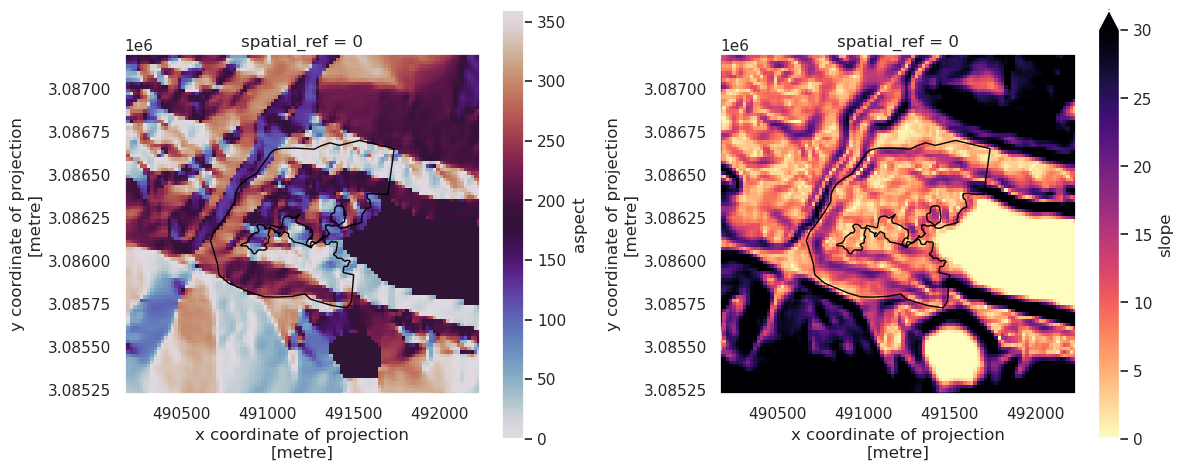

In [12]:
padding = 4500

f, ax = plt.subplots(1, 2, figsize=(12, 5))
geom_ds.aspect.plot(ax=ax[0], cmap='twilight', vmin=0, vmax=360)
dam_gdf.plot(ax=ax[0], edgecolor='black', facecolor='none')
ax[0].set_xlim(aoi_extent[0]+padding, aoi_extent[2]-padding)
ax[0].set_ylim(aoi_extent[3]+padding, aoi_extent[1]-padding)
ax[0].set_aspect('equal')
geom_ds.slope.plot(ax=ax[1], cmap='magma_r', vmin=0, vmax=30)
dam_gdf.plot(ax=ax[1], edgecolor='black', facecolor='none')
ax[1].set_xlim(aoi_extent[0]+padding, aoi_extent[2]-padding)
ax[1].set_ylim(aoi_extent[3]+padding, aoi_extent[1]-padding)
ax[1].set_aspect('equal')
f.tight_layout()

In [13]:
# construct slope-parallel and slope-normal unit vectors
# slope-parallel
geom_ds['parallel_n_hat'] = np.cos(np.radians(geom_ds.aspect))*np.sin(np.radians(90 - geom_ds.slope))
geom_ds['parallel_e_hat'] = np.sin(np.radians(geom_ds.aspect))*np.sin(np.radians(90 - geom_ds.slope))
geom_ds['parallel_z_hat'] = np.cos(np.radians(90 - geom_ds.slope))

geom_ds['normal_n_hat'] = np.cos((np.radians(geom_ds.aspect)-np.pi))*np.sin(np.radians(geom_ds.slope))
geom_ds['normal_e_hat'] = np.sin((np.radians(geom_ds.aspect)-np.pi))*np.sin(np.radians(geom_ds.slope))
geom_ds['normal_z_hat'] = np.cos(np.radians(geom_ds.slope))

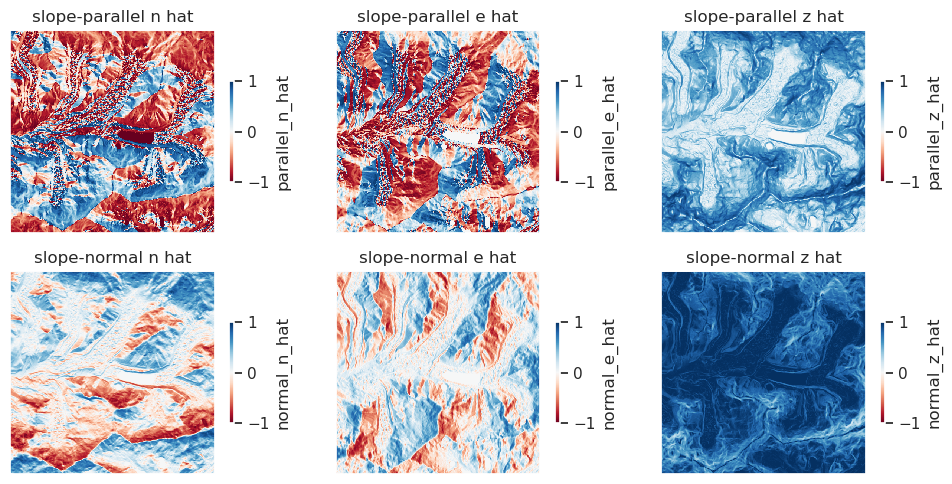

In [14]:
# plot unit look vectors 
f, ax = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey=True)
geom_ds.parallel_n_hat.plot(ax=ax[0, 0], vmin = -1, vmax=1, cbar_kwargs={'shrink': 0.5}, cmap='RdBu')
geom_ds.parallel_e_hat.plot(ax=ax[0, 1], vmin = -1, vmax=1, cbar_kwargs={'shrink': 0.5}, cmap='RdBu')
geom_ds.parallel_z_hat.plot(ax=ax[0, 2], vmin = -1, vmax=1, cbar_kwargs={'shrink': 0.5}, cmap='RdBu')

geom_ds.normal_n_hat.plot(ax=ax[1, 0], vmin = -1, vmax=1, cbar_kwargs={'shrink': 0.5}, cmap='RdBu')
geom_ds.normal_e_hat.plot(ax=ax[1, 1], vmin = -1, vmax=1, cbar_kwargs={'shrink': 0.5}, cmap='RdBu')
geom_ds.normal_z_hat.plot(ax=ax[1, 2], vmin = -1, vmax=1, cbar_kwargs={'shrink': 0.5}, cmap='RdBu')
ax[0, 0].set_aspect('equal')
ax[0, 1].set_aspect('equal')
ax[0, 2].set_aspect('equal')
ax[1, 0].set_aspect('equal')
ax[1, 1].set_aspect('equal')
ax[1, 2].set_aspect('equal')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])
ax[0, 0].set_xlabel('')
ax[0, 0].set_ylabel('')
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])
ax[0, 1].set_xlabel('')
ax[0, 1].set_ylabel('')
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])
ax[0, 2].set_xlabel('')
ax[0, 2].set_ylabel('')
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])
ax[1, 0].set_xlabel('')
ax[1, 0].set_ylabel('')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[1, 1].set_xlabel('')
ax[1, 1].set_ylabel('')
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])
ax[1, 2].set_xlabel('')
ax[1, 2].set_ylabel('')

ax[0, 0].set_title('slope-parallel n hat')
ax[0, 1].set_title('slope-parallel e hat')
ax[0, 2].set_title('slope-parallel z hat')
ax[1, 0].set_title('slope-normal n hat')
ax[1, 1].set_title('slope-normal e hat')
ax[1, 2].set_title('slope-normal z hat')
f.tight_layout()

In [15]:
# find dot products for LOS
asc_parallel = np.einsum('ijk,ijk->jk', np.array([asc_geom_ds['n_hat'].values, asc_geom_ds['e_hat'].values, asc_geom_ds['z_hat'].values]), np.array([geom_ds['parallel_n_hat'].values, geom_ds['parallel_e_hat'].values, geom_ds['parallel_z_hat'].values]))
asc_normal = np.einsum('ijk,ijk->jk', np.array([asc_geom_ds['n_hat'].values, asc_geom_ds['e_hat'].values, asc_geom_ds['z_hat'].values]), np.array([geom_ds['normal_n_hat'].values, geom_ds['normal_e_hat'].values, geom_ds['normal_z_hat'].values]))
des_parallel = np.einsum('ijk,ijk->jk', np.array([des_geom_ds['n_hat'].values, des_geom_ds['e_hat'].values, des_geom_ds['z_hat'].values]), np.array([geom_ds['parallel_n_hat'].values, geom_ds['parallel_e_hat'].values, geom_ds['parallel_z_hat'].values]))
des_normal = np.einsum('ijk,ijk->jk', np.array([des_geom_ds['n_hat'].values, des_geom_ds['e_hat'].values, des_geom_ds['z_hat'].values]), np.array([geom_ds['normal_n_hat'].values, geom_ds['normal_e_hat'].values, geom_ds['normal_z_hat'].values]))

In [16]:
# solve for horizontal and vertical displacement for all dates 
ts_ds['parallel_displacement'] = (asc_normal*ts_ds.des_displacement - des_normal*ts_ds.asc_displacement)/(asc_normal*des_parallel - des_normal*asc_parallel)
ts_ds['normal_displacement'] = ((asc_parallel*ts_ds['parallel_displacement']) - ts_ds.asc_displacement)/-asc_normal

In [17]:
decimal_years = ((ts_ds['time'] - np.datetime64('1970-01-01T00:00:00'))/np.timedelta64(1, 'ns')/1e9/3600/24/365.25)+1970
ts_ds = ts_ds.assign_coords(decimal_year = ('time', decimal_years.data))

In [18]:
# Function to fit a line to a 1D array and return the slope
def fit_line(x, y):
    valid_indices = ~np.isnan(y)
    try: 
        slope, _, _, _, _ = linregress(x[valid_indices], y[valid_indices])
    except: 
        return np.nan
    else:
        return slope

In [19]:
normal_veloc = xr.apply_ufunc(fit_line, ts_ds.decimal_year, ts_ds.normal_displacement, input_core_dims=[['time'], ['time']], vectorize=True)
parallel_veloc = xr.apply_ufunc(fit_line, ts_ds.decimal_year, ts_ds.parallel_displacement, input_core_dims=[['time'], ['time']], vectorize=True)

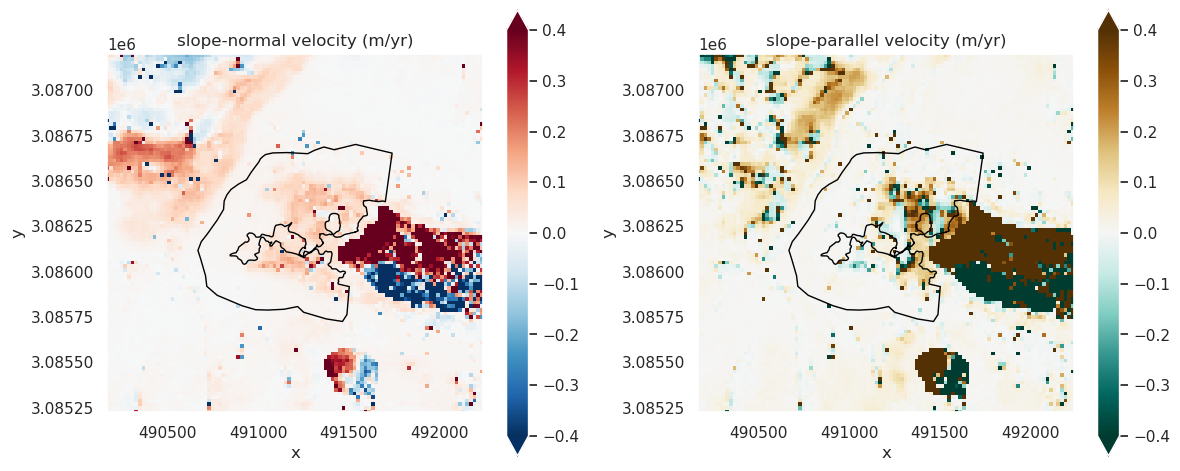

In [20]:
padding = 4500

# plot normal and parallel velocity
f, ax = plt.subplots(1, 2, figsize=(12, 5))
normal_veloc.plot(ax=ax[0], cmap='RdBu_r', vmin=-0.4, vmax=0.4)
dam_gdf.plot(ax=ax[0], edgecolor='black', facecolor='none')
ax[0].set_xlim(aoi_extent[0]+padding, aoi_extent[2]-padding)
ax[0].set_ylim(aoi_extent[3]+padding, aoi_extent[1]-padding)
parallel_veloc.plot(ax=ax[1], cmap='BrBG_r', vmin=-0.4, vmax=0.4)
dam_gdf.plot(ax=ax[1], edgecolor='black', facecolor='none')
ax[1].set_xlim(aoi_extent[0]+padding, aoi_extent[2]-padding)
ax[1].set_ylim(aoi_extent[3]+padding, aoi_extent[1]-padding)
ax[0].set_title('slope-normal velocity (m/yr)')
ax[1].set_title('slope-parallel velocity (m/yr)')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
f.tight_layout()
plt.savefig('./figs/normal_parallel_velocity.png', dpi=300)

In [21]:
# write to rasters
normal_veloc = normal_veloc.rio.write_crs(crs)
normal_veloc.rio.to_raster(f'normal_velocity_{dam_name}.tif')
parallel_veloc = parallel_veloc.rio.write_crs(crs)
parallel_veloc.rio.to_raster(f'parallel_velocity_{dam_name}.tif')

In [22]:
moving_ts = ts_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs, drop=True)

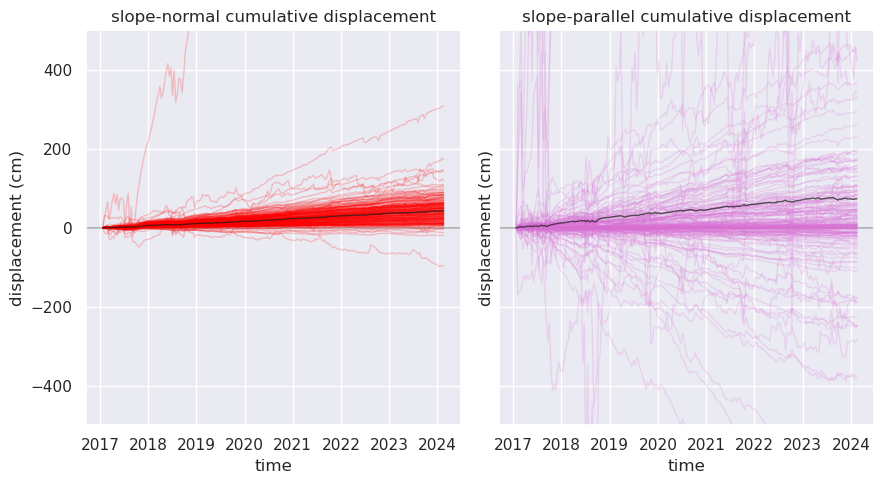

In [23]:
f, ax = plt.subplots(1, 2, figsize=(9,5), sharex=True, sharey=True)
ax[0].axhline(y=0, c='gray', alpha=0.5)
for x in range(len(moving_ts.x)):
    for y in range(len(moving_ts.y)):
        if (x+1) % 2 + (y+1) % 2 == 0:
            (moving_ts.normal_displacement.isel(x=x, y=y)*100).plot(ax=ax[0], c='red', linewidth=1, alpha=0.2)
(moving_ts.normal_displacement.median(dim=('x', 'y'))*100).plot(ax=ax[0], c='k', linewidth=1, alpha=0.7)

ax[1].axhline(y=0, c='gray', alpha=0.5)
for x in range(len(moving_ts.x)):
    for y in range(len(moving_ts.y)):
        if (x+1) % 2 + (y+1) % 2 == 0:
            (moving_ts.parallel_displacement.isel(x=x, y=y)*100).plot(ax=ax[1], c='orchid', linewidth=1, alpha=0.2)
(moving_ts.parallel_displacement.mean(dim=('x', 'y'))*100).plot(ax=ax[1], c='k', linewidth=1, alpha=0.7)

ax[0].set_ylim(-500, 500)

ax[1].set_ylim(-500, 500)

ax[0].set_title('slope-normal cumulative displacement')
ax[0].set_ylabel('displacement (cm)')
ax[1].set_title('slope-parallel cumulative displacement')
ax[1].set_ylabel('displacement (cm)')
f.tight_layout()
plt.savefig(f'./figs/{dam_name}_slope_decomp_pixels_ts.png', dpi=300)

In [24]:
moving_ts_weekly = moving_ts

In [25]:
moving_ts_weekly['normal_velocity'] = moving_ts_weekly.normal_displacement.differentiate(coord='time', edge_order=1, datetime_unit='D')*365.25
moving_ts_weekly['parallel_velocity'] = moving_ts_weekly.parallel_displacement.differentiate(coord='time', edge_order=1, datetime_unit='D')*365.25

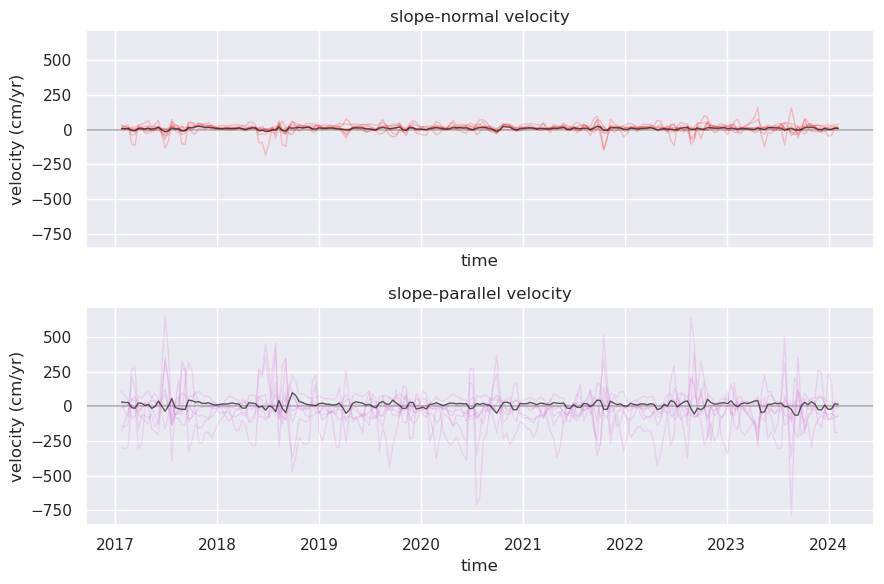

In [26]:
f, ax = plt.subplots(2, 1, figsize=(9,6), sharex=True, sharey=True)
ax[0].axhline(y=0, c='gray', alpha=0.5)
for x in range(len(moving_ts_weekly.x)):
    for y in range(len(moving_ts_weekly.y)):
        if (x+1) % 10 + (y+1) % 10 == 0:
            (moving_ts_weekly.normal_velocity.isel(x=x, y=y)*100).plot(ax=ax[0], c='red', linewidth=1, alpha=0.2)
(moving_ts_weekly.normal_velocity.mean(dim=('x', 'y'))*100).plot(ax=ax[0], c='k', linewidth=1, alpha=0.7)

ax[1].axhline(y=0, c='gray', alpha=0.5)
for x in range(len(moving_ts_weekly.x)):
    for y in range(len(moving_ts_weekly.y)):
        if (x+1) % 10 + (y+1) % 10 == 0:
            (moving_ts_weekly.parallel_velocity.isel(x=x, y=y)*100).plot(ax=ax[1], c='orchid', linewidth=1, alpha=0.2)
(moving_ts_weekly.parallel_velocity.mean(dim=('x', 'y'))*100).plot(ax=ax[1], c='k', linewidth=1, alpha=0.7)

# ax[0].set_ylim(-20, 20)
# ax[1].set_ylim(-20, 20)

ax[0].set_title('slope-normal velocity')
ax[0].set_ylabel('velocity (cm/yr)')
ax[1].set_title('slope-parallel velocity')
ax[1].set_ylabel('velocity (cm/yr)')
f.tight_layout()
#plt.savefig(f'./figs/{dam_name}_decomp_pixels_ts.png', dpi=300)

In [27]:
moving_months = moving_ts_weekly.groupby(moving_ts_weekly.time.dt.month).median()

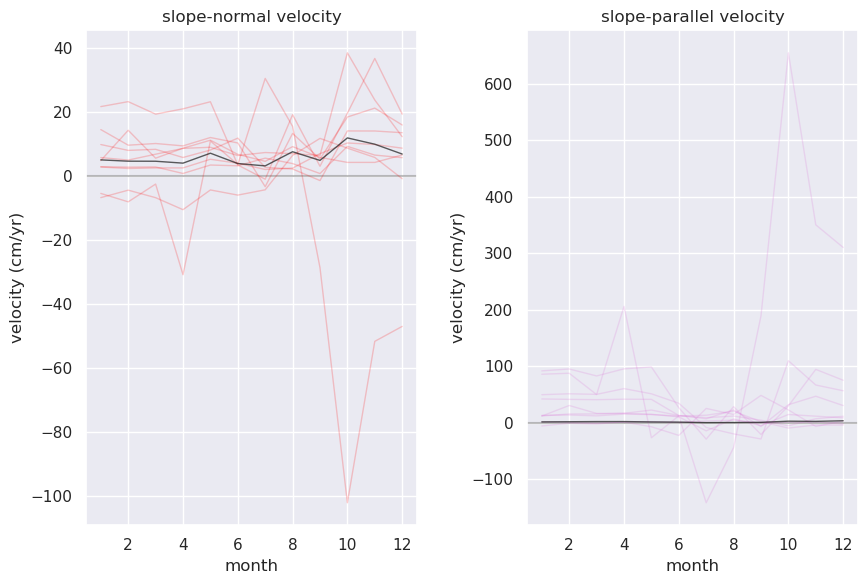

In [28]:
f, ax = plt.subplots(1, 2, figsize=(9,6), sharex=True, sharey=False)
ax[0].axhline(y=0, c='gray', alpha=0.5)
for x in range(len(moving_months.x)):
    for y in range(len(moving_months.y)):
        if (x+1) % 8 + (y+1) % 8 == 0:
            (moving_months.normal_velocity.isel(x=x, y=y)*100).plot(ax=ax[0], c='red', linewidth=1, alpha=0.2)
(moving_months.normal_velocity.median(dim=('x', 'y'))*100).plot(ax=ax[0], c='k', linewidth=1, alpha=0.7)

ax[1].axhline(y=0, c='gray', alpha=0.5)
for x in range(len(moving_months.x)):
    for y in range(len(moving_months.y)):
        if (x+1) % 8 + (y+1) % 8 == 0:
            (moving_months.parallel_velocity.isel(x=x, y=y)*100).plot(ax=ax[1], c='orchid', linewidth=1, alpha=0.2)
(moving_months.parallel_velocity.median(dim=('x', 'y'))*100).plot(ax=ax[1], c='k', linewidth=1, alpha=0.7)

ax[0].set_title('slope-normal velocity')
ax[0].set_ylabel('velocity (cm/yr)')
ax[1].set_title('slope-parallel velocity')
ax[1].set_ylabel('velocity (cm/yr)')
f.tight_layout()

In [29]:
ones = xr.ones_like(moving_months.normal_velocity)
months_broadcast = ones*moving_months.month

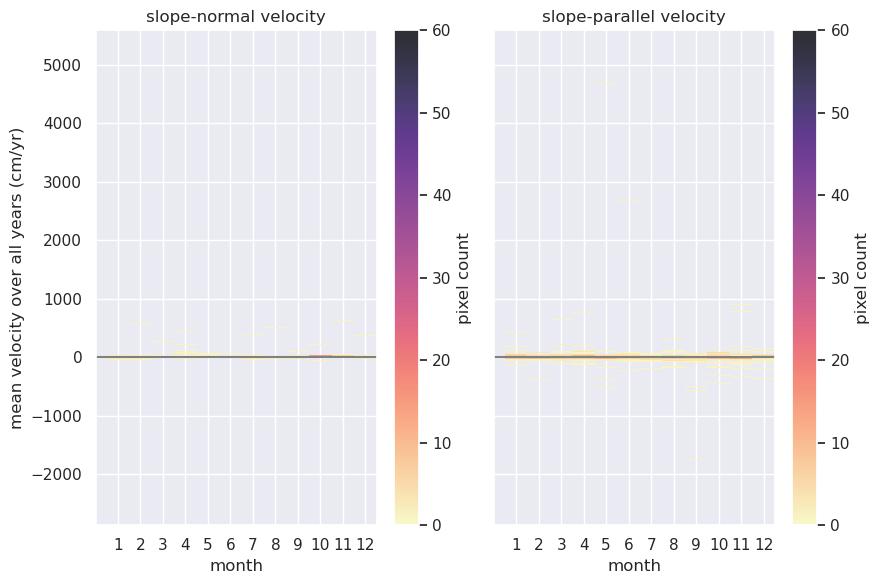

In [30]:
f, ax = plt.subplots(1, 2, figsize=(9, 6), sharex=True, sharey=True)
ax[0].axhline(y=0, c='gray', alpha=1)
ax[1].axhline(y=0, c='gray', alpha=1)
sns.histplot(ax=ax[0], x=months_broadcast.values.flatten(), y = moving_months.normal_velocity.values.flatten()*100, cbar=True, discrete=(True, False), binwidth=2, vmax=60, cmap='magma_r', alpha=0.8, cbar_kws={'label':'pixel count'})
sns.histplot(ax=ax[1], x=months_broadcast.values.flatten(), y = moving_months.parallel_velocity.values.flatten()*100, cbar=True, discrete=(True, False), binwidth=2, vmax=60, cmap='magma_r', alpha=0.8, cbar_kws={'label':'pixel count'})
ax[0].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[1].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[0].set_xlim(0, 12.5)
ax[1].set_xlim(0, 12.5)
ax[0].set_ylabel('mean velocity over all years (cm/yr)')
ax[0].set_xlabel('month')
ax[1].set_xlabel('month')
ax[0].set_title('slope-normal velocity')
ax[1].set_title('slope-parallel velocity')
f.tight_layout()
plt.savefig(f'./figs/{dam_name}_slope_velocity.png', dpi=300)

In [31]:
# repeat interpolation and grouping with all pixels
# moving_ts_weekly_allpix = ts_ds.resample(time='2W').interpolate('linear')
moving_ts_weekly_allpix = ts_ds
moving_ts_weekly_allpix['normal_velocity'] = moving_ts_weekly_allpix.normal_displacement.differentiate(coord='time', edge_order=1, datetime_unit='D')*365.25
moving_ts_weekly_allpix['parallel_velocity'] = moving_ts_weekly_allpix.parallel_displacement.differentiate(coord='time', edge_order=1, datetime_unit='D')*365.25
moving_ts_weekly_allpix['asc_velocity'] = moving_ts_weekly_allpix.asc_displacement.differentiate(coord='time', edge_order=1, datetime_unit='D')*365.25
moving_ts_weekly_allpix['des_velocity'] = moving_ts_weekly_allpix.des_displacement.differentiate(coord='time', edge_order=1, datetime_unit='D')*365.25
moving_months_allpix = moving_ts_weekly_allpix.groupby(moving_ts_weekly_allpix.time.dt.month).median()

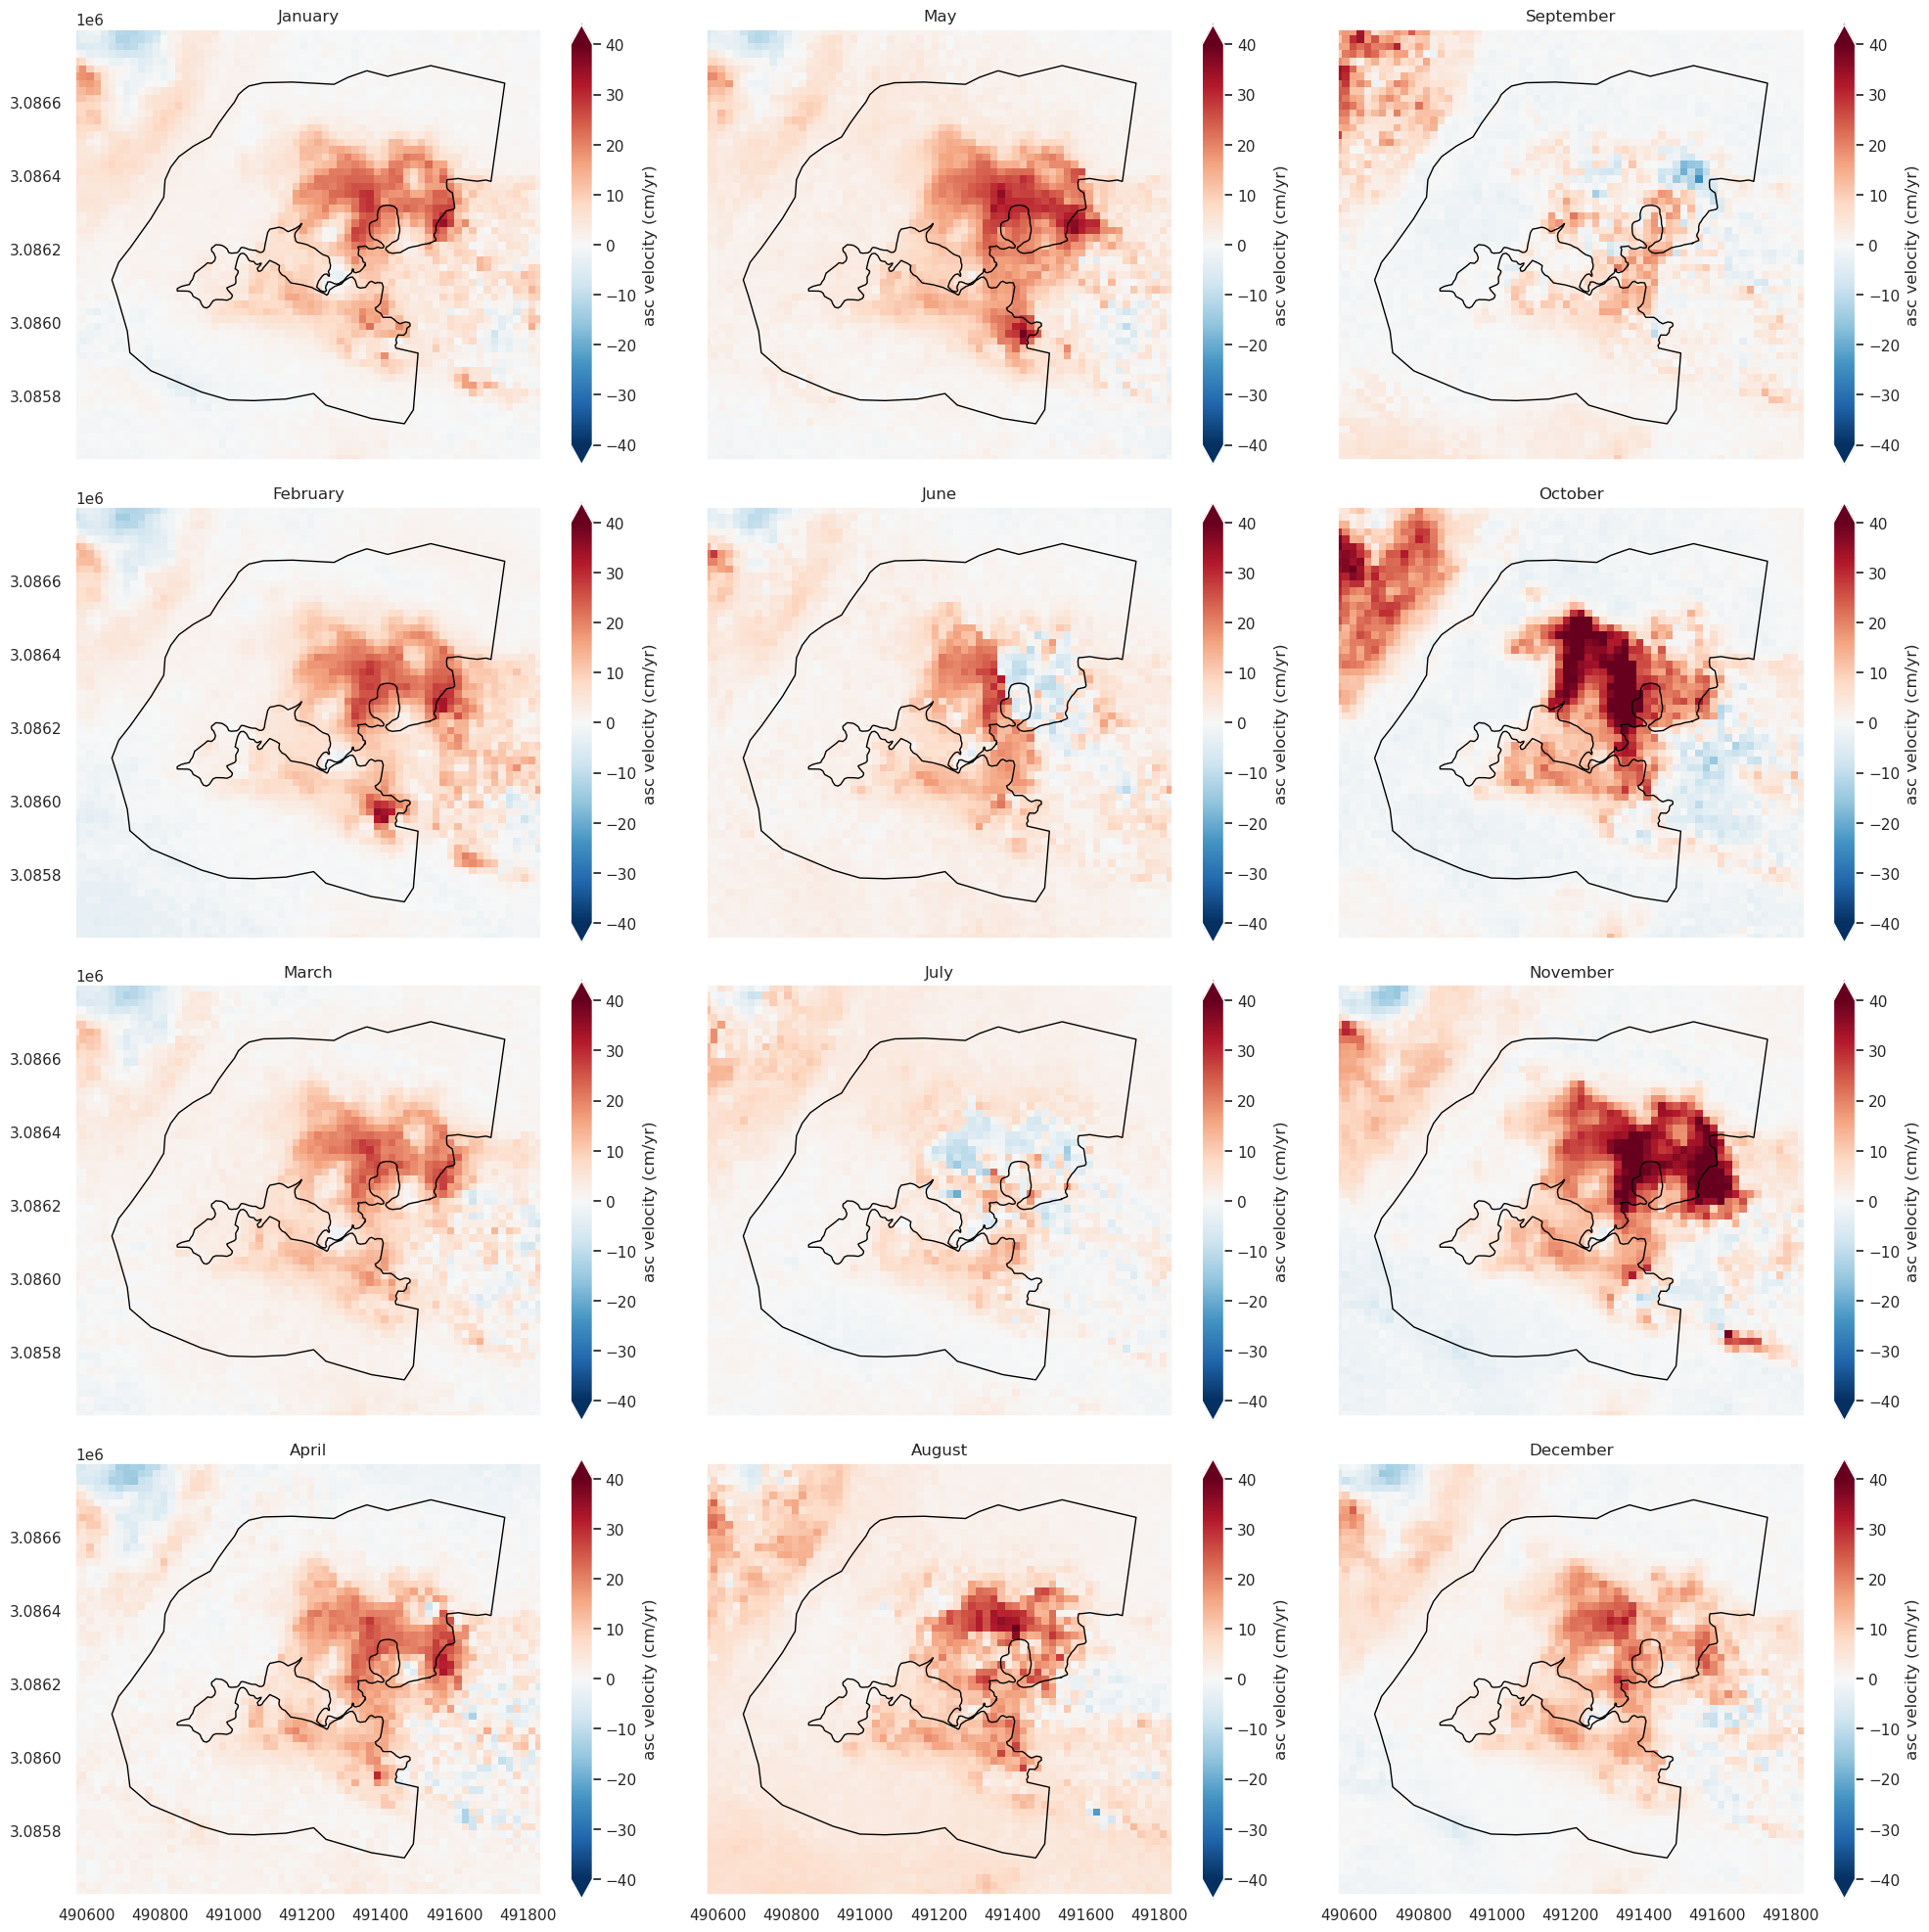

In [32]:
# plot monthly velocity maps
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
f, axs = plt.subplots(4, 3, figsize=(20, 20), sharex=True, sharey=True)
for i, month in enumerate(months):
    ax = axs[i % 4, i // 4]
    (moving_months_allpix.isel(month=i).asc_velocity*100).plot(ax=ax, cmap='RdBu_r', vmin=-40, vmax=40, cbar_kwargs={'label':'asc velocity (cm/yr)'})
    dam_gdf.plot(ax=ax, edgecolor='black', facecolor='none')
    ax.set_xlim(aoi_extent[0]+4900, aoi_extent[2]-4900)
    ax.set_ylim(aoi_extent[3]+4900, aoi_extent[1]-4900)
    ax.set_title(month)
    ax.set_aspect('equal')
    ax.set_xlabel('')
    ax.set_ylabel('')
f.tight_layout()
plt.savefig('./figs/asc_velocity_maps.png', dpi=300)

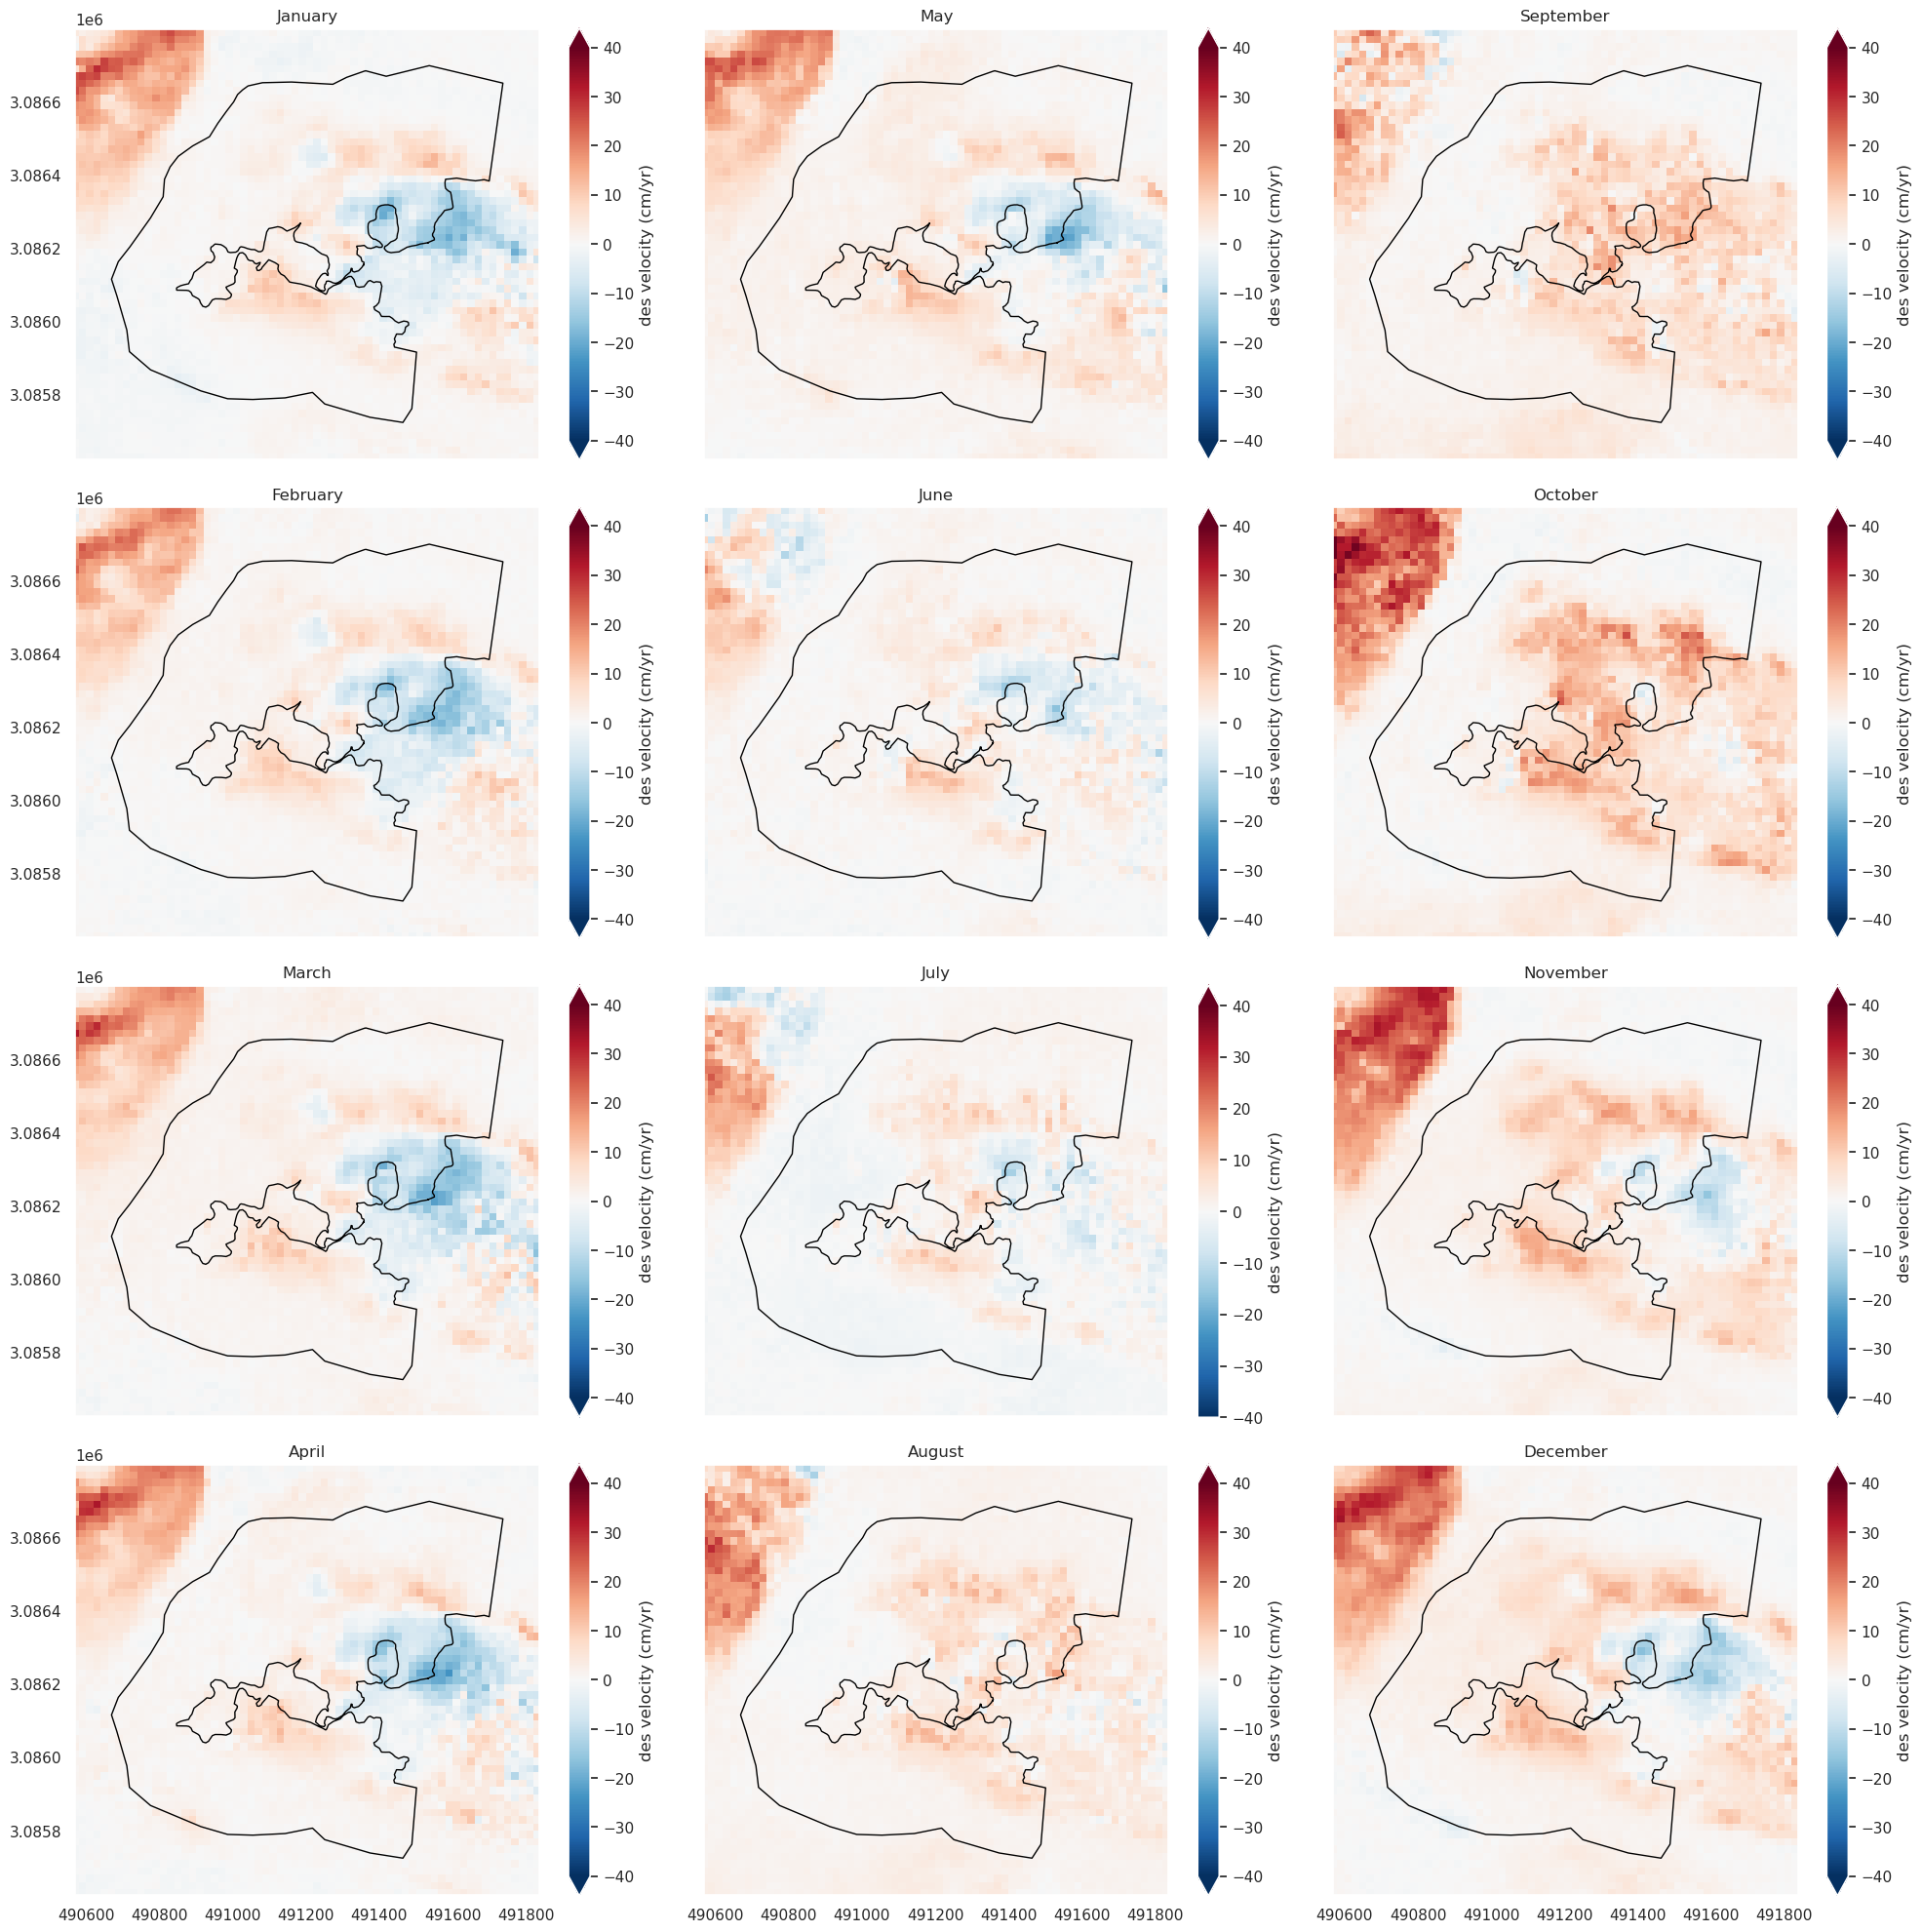

In [33]:
# plot monthly velocity maps
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
f, axs = plt.subplots(4, 3, figsize=(20, 20), sharex=True, sharey=True)
for i, month in enumerate(months):
    ax = axs[i % 4, i // 4]
    (moving_months_allpix.isel(month=i).des_velocity*100).plot(ax=ax, cmap='RdBu_r', vmin=-40, vmax=40, cbar_kwargs={'label':'des velocity (cm/yr)'})
    dam_gdf.plot(ax=ax, edgecolor='black', facecolor='none')
    ax.set_xlim(aoi_extent[0]+4900, aoi_extent[2]-4900)
    ax.set_ylim(aoi_extent[3]+4900, aoi_extent[1]-4900)
    ax.set_title(month)
    ax.set_aspect('equal')
    ax.set_xlabel('')
    ax.set_ylabel('')
f.tight_layout()
plt.savefig('./figs/des_velocity_maps.png', dpi=300)

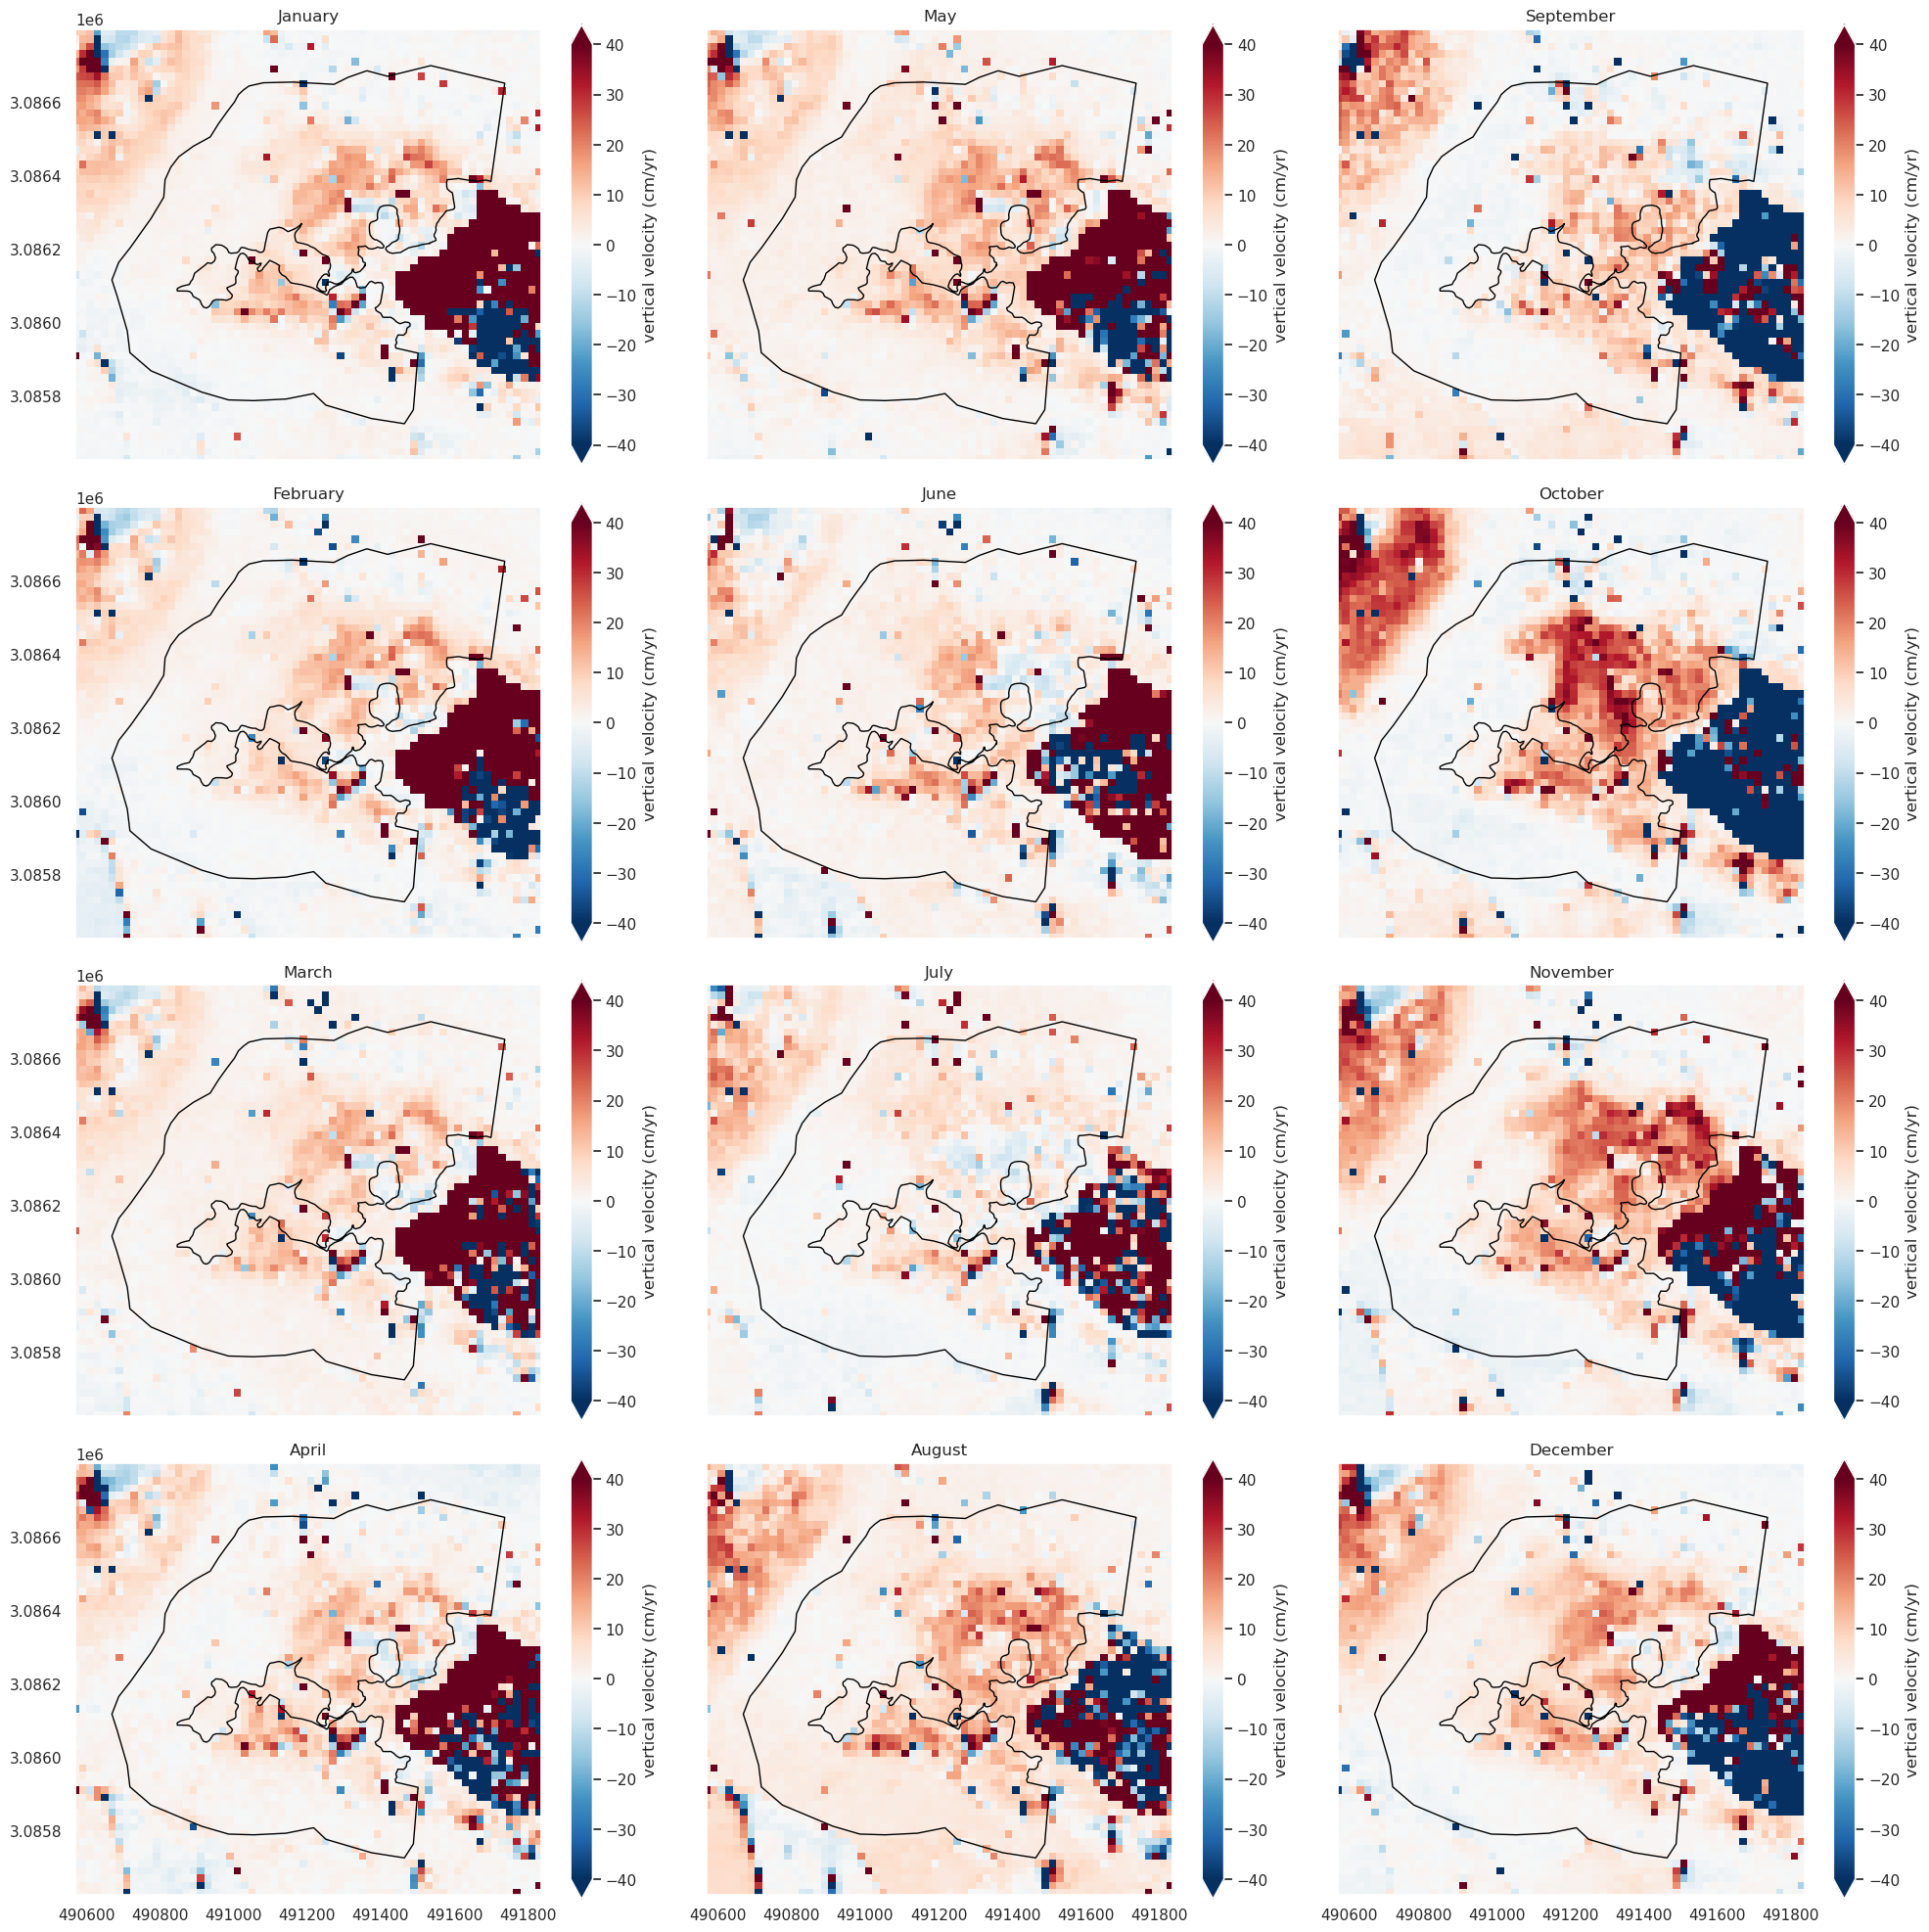

In [34]:
# plot monthly velocity maps
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
f, axs = plt.subplots(4, 3, figsize=(20, 20), sharex=True, sharey=True)
for i, month in enumerate(months):
    ax = axs[i % 4, i // 4]
    (moving_months_allpix.isel(month=i).normal_velocity*100).plot(ax=ax, cmap='RdBu_r', vmin=-40, vmax=40, cbar_kwargs={'label':'vertical velocity (cm/yr)'})
    dam_gdf.plot(ax=ax, edgecolor='black', facecolor='none')
    ax.set_xlim(aoi_extent[0]+4900, aoi_extent[2]-4900)
    ax.set_ylim(aoi_extent[3]+4900, aoi_extent[1]-4900)
    ax.set_title(month)
    ax.set_aspect('equal')
    ax.set_xlabel('')
    ax.set_ylabel('')
f.tight_layout()
plt.savefig('./figs/normal_velocity_maps.png', dpi=300)

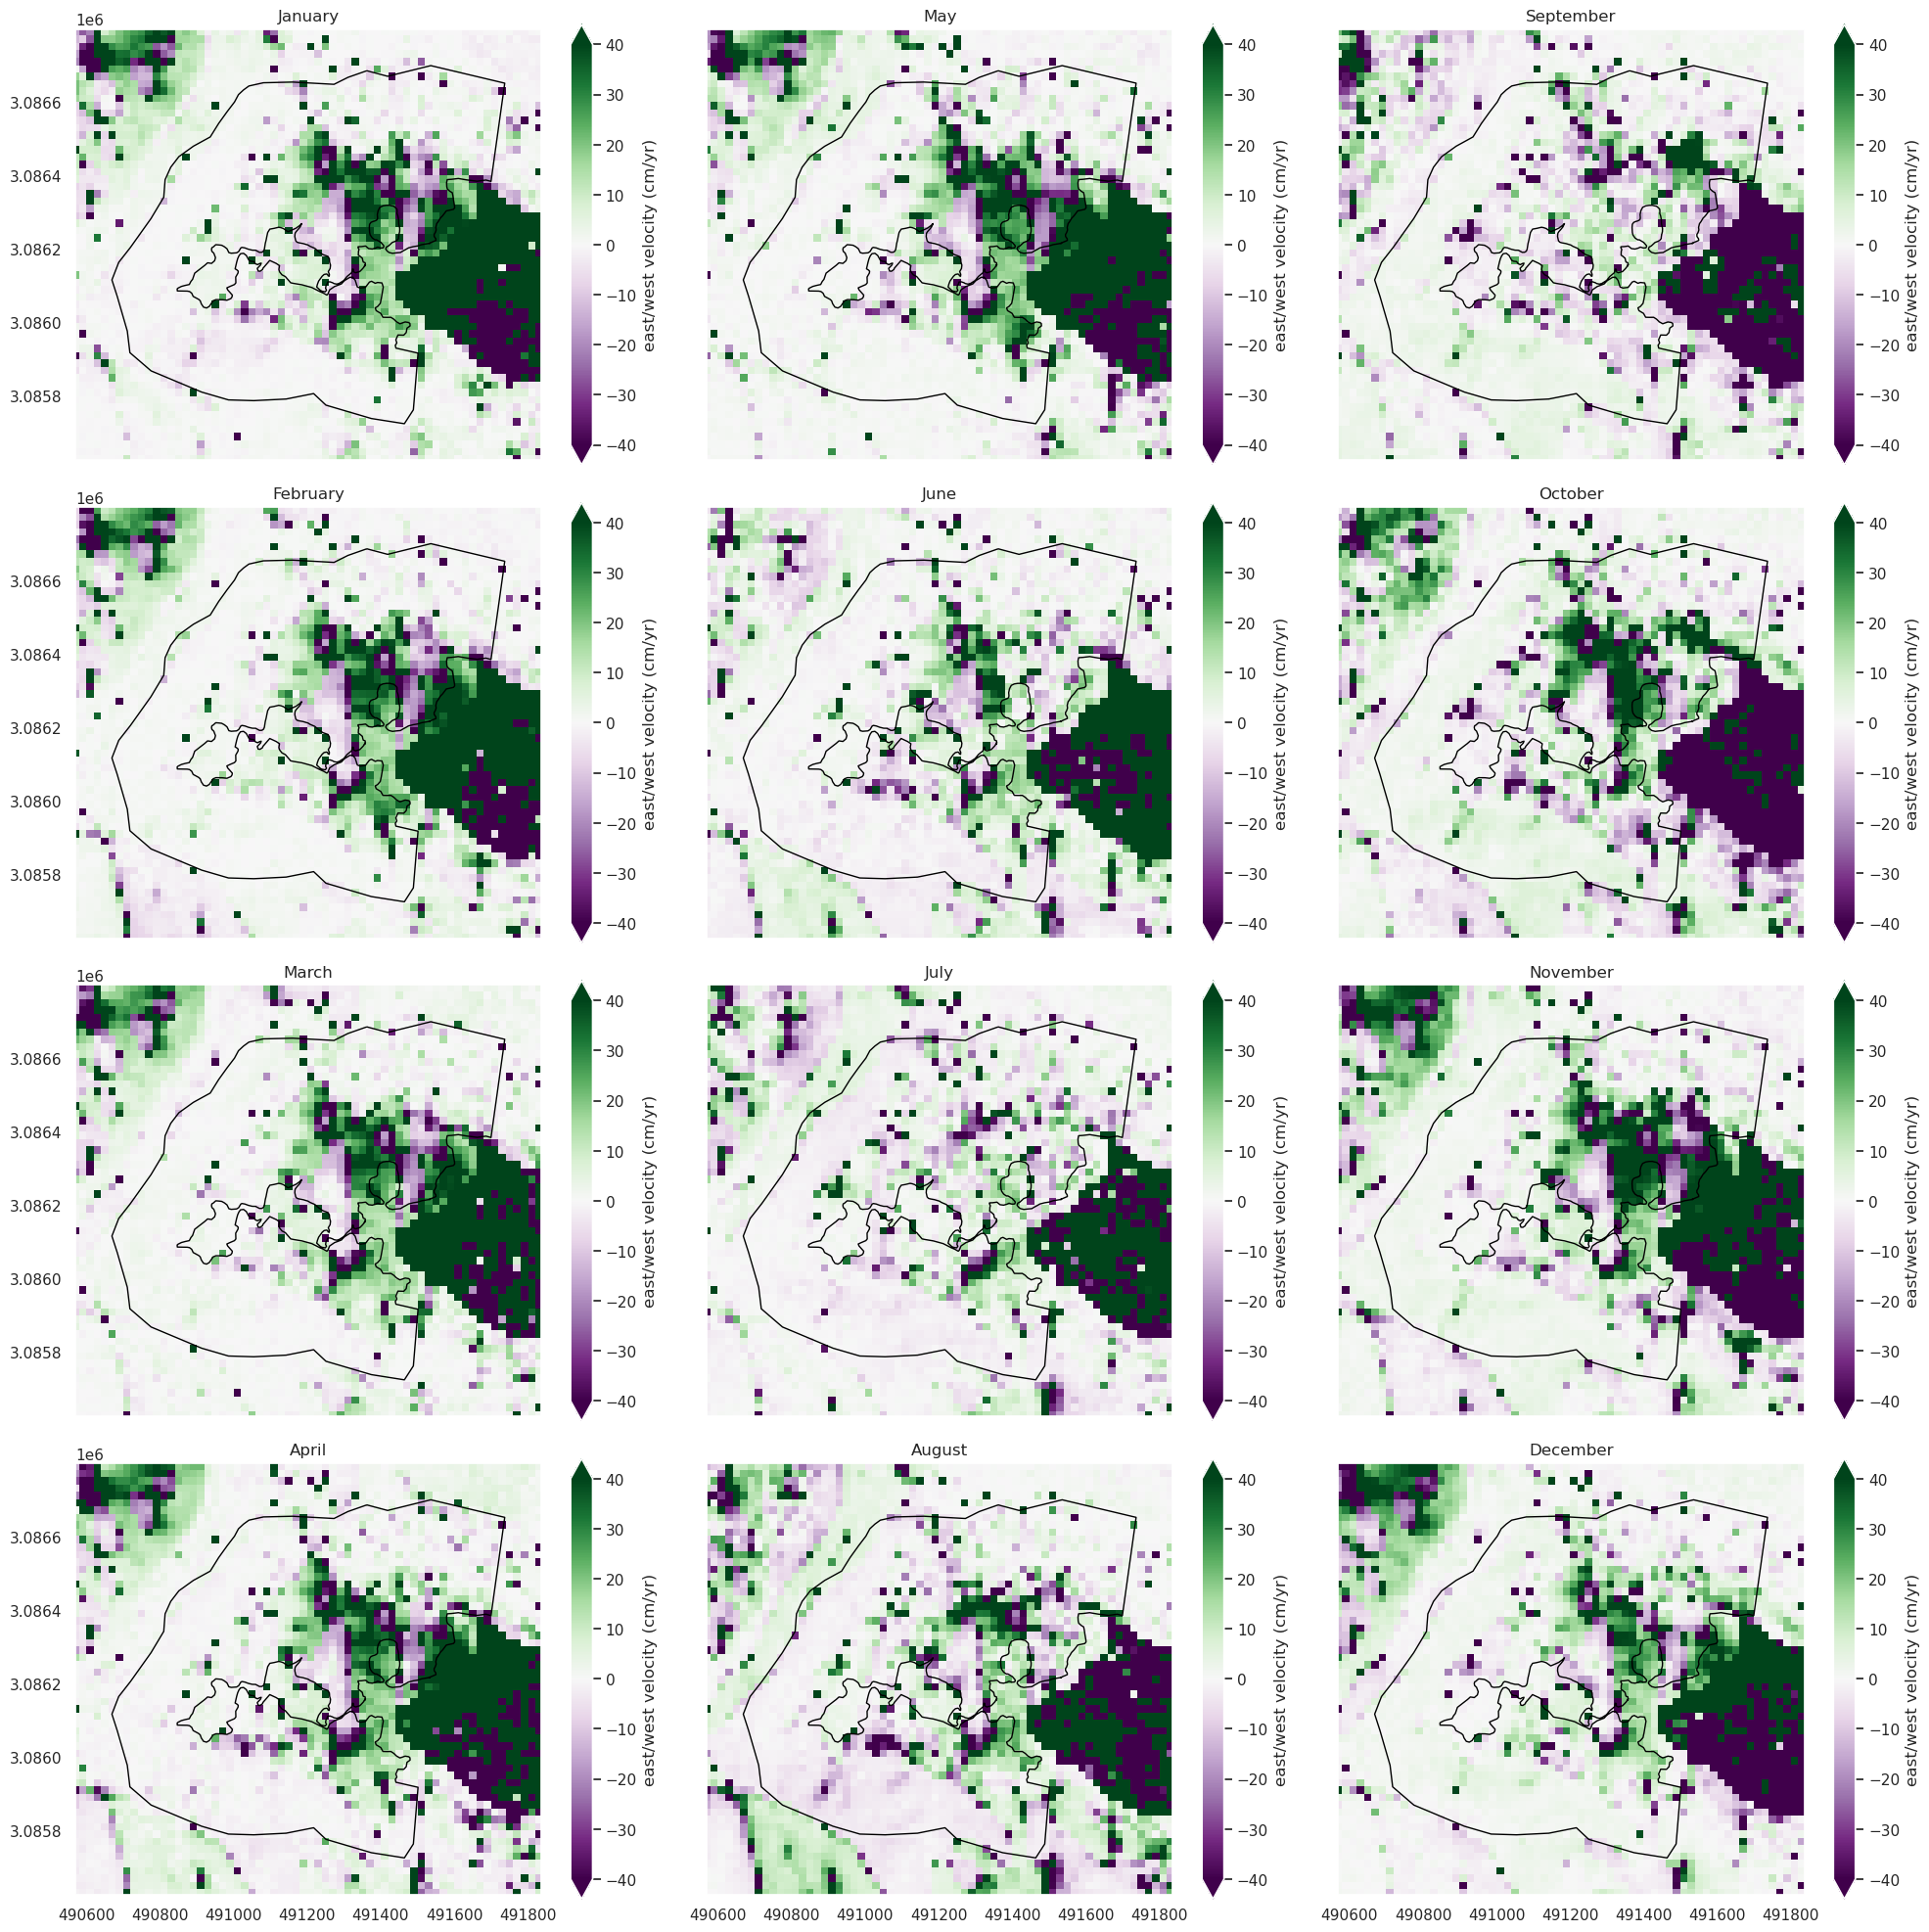

In [35]:
# plot monthly velocity maps
f, axs = plt.subplots(4, 3, figsize=(20, 20), sharex=True, sharey=True)
for i, month in enumerate(months):
    ax = axs[i % 4, i // 4]
    (moving_months_allpix.isel(month=i).parallel_velocity*100).plot(ax=ax, cmap='PRGn', vmin=-40, vmax=40, cbar_kwargs={'label':'east/west velocity (cm/yr)'})
    dam_gdf.plot(ax=ax, edgecolor='black', facecolor='none')
    ax.set_xlim(aoi_extent[0]+4900, aoi_extent[2]-4900)
    ax.set_ylim(aoi_extent[3]+4900, aoi_extent[1]-4900)
    ax.set_title(month)
    ax.set_aspect('equal')
    ax.set_xlabel('')
    ax.set_ylabel('')
f.tight_layout()
plt.savefig('./figs/parallel_velocity_maps.png', dpi=300)